# BigQuery ML Forecasting: A Blended Model Approach

Since January 2025 BigQuery ARIMA_PLUS_XREG is no longer available, which is a shame because it was a great way to add external features to your data.

External features usually because we know factors such as "discount", "method of delivery" and "marketing spend" can all impact the quantity sold. However this does not mean we cannot continue to use this approach we just need to be a bit more creative on how to approach it. 

This notebook will cover how we will applied a blended model approach using BigQuery's ARIMA+ and a XGboost regressor to create a similar model.

## How this notebook works

This notebook is deployed via a Vertex AI workbench notebook using a Tensorflow set up. Tensorflow set up is just a personal preference not required for this notebook. Because I am using Vertex AI workbench several of the key libraries are already installed for me.

For details on how to set up a Vertex AI work bench follow this link: https://cloud.google.com/vertex-ai/docs/workbench/instances/create


## How will we create the blended model

Here what we are going to do is create one ARIMA+ model and 1 XGboost regressor model using BigQuery ML. 

Then we are going to evaluate and then build 1 single prediction using both model.s

The XGboost model will allow us to use external features such as discount. While the ARIMA+ model will allow us to use the ARIMA forecasting capabilities.

Then we will create a blended forecast.

In [5]:
import os
import time
import gc
import argparse
import requests
import shutil
import io

#Data Science Libraries
import pandas as pd
import numpy as np

#Import Math, Systems and Date Libraries
import math
import sys
import warnings
import datetime
import pickle

#Google Cloud Libraries
from google.cloud import bigquery as bq
from google.cloud import storage

In [6]:
#Change if you are using a different project
%env GOOGLE_CLOUD_PROJECT= 'a-better-mistake-2021'

env: GOOGLE_CLOUD_PROJECT='a-better-mistake-2021'


## Helper functions

This functions are just to help create a smoother model building experience

In [7]:
def bq_job_config(start_date,end_date):
    
    job_config = bq.QueryJobConfig()
    return job_config

In [8]:
def generate_sql(sql_,project_id,start_date,end_date):
    
    client = bq.Client(project=project_id)
    job_config = bq_job_config(start_date,end_date)
    print(job_config)
    try:
        print("Try Block")
        query = client.query(sql_,job_config=job_config)
    except:
        print("Error in query")
    return query

In [9]:
def create_bqml_model(sql_statement):
    """Executes a BigQuery SQL query and creates a BQML model.

    Args:
        sql_statement (str): The SQL query to execute.

    Returns:
        model creation output
    """

    # Create a BigQuery client
    client = bq.Client(project="a-better-mistake-2021")

    # Execute the query and wait for results
    query_job = client.query(sql_statement)  
    results = query_job.result()  

    # Convert the results to a pandas DataFrame
    return results

In [10]:
def read_bigquery_data(sql_statement):
    # Set up BigQuery client
    client = bq.Client(project="a-better-mistake-2021")

    # Run the SQL query
    query_job = client.query(sql_statement)

    # Convert query results to a pandas DataFrame
    dataframe = query_job.to_dataframe()

    return dataframe

In [11]:
def execute_query_to_dataframe(sql_statement):
    """Executes a BigQuery SQL query and returns the results as a pandas DataFrame.

    Args:
        sql_statement (str): The SQL query to execute.

    Returns:
        pandas.DataFrame: The results of the BigQuery query.
    """

    # Create a BigQuery client
    client = bq.Client()

    # Execute the query and wait for results
    query_job = client.query(sql_statement)  
    results = query_job.result()  

    # Convert the results to a pandas DataFrame
    return results.to_dataframe()

In [12]:
def get_data(sql_, project_id, start_date, end_date):

    client = bq.Client(project=project_id)
    job_config = bq_job_config(start_date,end_date)
    try:
        df = client.query(sql_,job_config=job_config)
    except:
        print("Error getting data")
    
    df = df.to_dataframe(progress_bar_type='tqdm') # Converts to dataframe
    
    return df

In [13]:
def add_to_table(dest_table_id, sql,bq_table_exists=True):
    
    # Construct a BigQuery client object.
    client = bq.Client()
    
    if bq_table_exists:
        write_disposition = "WRITE_TRUNCATE"
    else:
        write_disposition = "WRITE_EMPTY"
    
    job_config = bq.QueryJobConfig(
        # Set our destination table
        destination=dest_table_id,
        
        # setting to add to the destination table if it already exists 
        write_disposition= write_disposition,
        create_disposition='CREATE_IF_NEEDED'
    )
    
    query_job = client.query(sql, job_config=job_config, )  # Make an API request.
    query_job.result() # Wait for result

    return

In [14]:
def load_dataframe_to_bigquery(dataframe,table_id,job_config):
    bq_job = bq_client.load_table_from_dataframe(
    vision_df, table_id, job_config=bq_job_config
    )  # Make an API request.
    return bq_job.result() 

In [15]:
def read_data(filename,num_rows):
    df = pd.read_csv(filename,nrows=num_rows,delimiter="|")
    return df

In [16]:
def create_gcp_bucket(client,bucket_name):
    storage_client = client
    bucket = storage_client.bucket(bucket_name)
    return bucket

In [17]:
def create_bigquery_table(dataframe, project_id, dataset_id, table_id):
    # Initialize BigQuery client
    client = bq.Client(project=project_id)

    # Create dataset if it doesn't exist
    dataset_ref = client.dataset(dataset_id)
    dataset = bq.Dataset(dataset_ref)
    dataset.location = "US"
    dataset = client.create_dataset(dataset, exists_ok=True)

    # Convert DataFrame to BigQuery table
    table_ref = dataset.table(table_id)
    print(table_ref)
    job_config = bq.LoadJobConfig()
    job_config.write_disposition = bq.WriteDisposition.WRITE_TRUNCATE
    job = client.load_table_from_dataframe(dataframe, table_ref, job_config=job_config)
    job.result()

    print(f"Table {table_id} created successfully in BigQuery.")

## ARIMA Model Build

In [18]:
#Environment ARIMA Variables
PROJECT_ID = "a-better-mistake-2021"
dataset_id = "aster_uat"
training_table_id = "sku_arima_regression_quantity_training_data"
evaluation_table_id = "sku_arima_regression_quantity_evaluation_data"
prediction_table_id = "sku_arima_regression_quantity_prediction_data"

In [21]:
#ARIMA Training Data
SKU_ARIMA_TRAINING_CREATION_SQL_PATH = "sql/arima/quantity/arima_training_quantity_data.sql"

In [22]:
#ARIMA Training Data
CREATE_ARIMA_SQL_PATH = "sql/arima/quantity/create_arima_quantity_model.sql"

In [25]:
#Create SKU Training Table
train_sql_query = open(SKU_ARIMA_TRAINING_CREATION_SQL_PATH ).read()

In [26]:
#Create ARIMA Dataframe
train_df = read_bigquery_data(train_sql_query)
train_df.head()

,date,item_id,store_id,quantity
0,2024-01-02,1000111,1278,1.0
1,2024-01-02,1000314,1278,1.0
2,2024-01-02,1001151,1278,2.0
3,2024-01-02,1001417,1278,1.0
4,2024-01-02,1002429,1278,1.0


In [27]:
#Create Training Data for ARIMA+ Model
create_bigquery_table(train_df, PROJECT_ID, dataset_id, training_table_id)

a-better-mistake-2021.aster_uat.sku_arima_regression_quantity_training_data
Table sku_arima_regression_quantity_training_data created successfully in BigQuery.


In [28]:
#ARIMA Training Data
CREATE_ARIMA_SQL_PATH = "sql/arima/quantity/create_arima_quantity_model.sql"

In [29]:
#Read ARIMA Model
create_arima_model_query = open(CREATE_ARIMA_SQL_PATH).read()

In [30]:
#Create ARIMA Model
create_bqml_model(create_arima_model_query)

In [31]:
#Evaluation Results
ARIMA_EVALUATION_SQL_PATH = "sql/arima/quantity/arima_evaluation_data.sql"

In [32]:
arima_evaluation_query = open(ARIMA_EVALUATION_SQL_PATH).read()

In [33]:
#Create Dataframe
arima_eval_df = read_bigquery_data(arima_evaluation_query)
arima_eval_df.head()

,date,real_quantity,upper_forecast,avg_forecast,lower_forecast
0,2024-12-11,1177.0,4193.4,3031.5,1869.8
1,2024-12-12,1470.0,4320.1,2940.1,1560.4
2,2024-12-13,1354.0,3905.8,2675.4,1444.8
3,2024-12-14,1384.0,4421.4,2970.1,1518.3
4,2024-12-15,1459.0,4351.1,2905.8,1460.1


In [34]:
import matplotlib.pyplot as plt

In [35]:
#ARIMA forecast
# Create the plot
plt.figure(figsize=(10, 6)) 

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

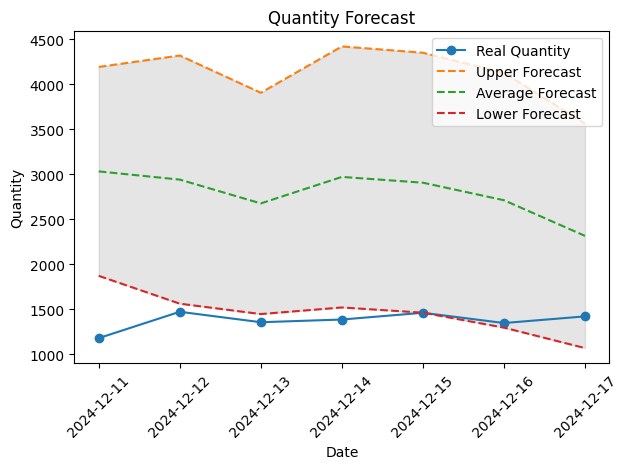

In [36]:
# Plot the lines
plt.plot(arima_eval_df['date'], arima_eval_df['real_quantity'], label='Real Quantity', marker='o')
plt.plot(arima_eval_df['date'], arima_eval_df['upper_forecast'], label='Upper Forecast', linestyle='--')
plt.plot(arima_eval_df['date'], arima_eval_df['avg_forecast'], label='Average Forecast', linestyle='--')
plt.plot(arima_eval_df['date'], arima_eval_df['lower_forecast'], label='Lower Forecast', linestyle='--')

# Fill between the forecast lines
plt.fill_between(arima_eval_df['date'], arima_eval_df['lower_forecast'], arima_eval_df['upper_forecast'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Quantity Forecast')
plt.legend()

# Format the x-axis (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [37]:
#Save ARIMA Prediction Table to BigQuery
SKU_ARIMA_PREDICITION_PATH = "sql/arima/quantity/arima_prediction_data.sql"

In [38]:
arima_prediction_data_query = open(SKU_ARIMA_PREDICITION_PATH).read()

In [39]:
#Create Regression Evaluation Dataframe
arima_preds_df = read_bigquery_data(arima_prediction_data_query)
arima_preds_df.head()

,date,store_id,item_id,upper_forecast,avg_forecast,lower_forecast
0,2024-12-11,1289,1007802,6.0,4.0,2.0
1,2024-12-11,1278,1007244,1.1,1.0,0.8
2,2024-12-11,1119,1011523,3.0,1.7,0.4
3,2024-12-11,1278,1000915,4.5,3.9,3.2
4,2024-12-11,1278,1054618,4.8,4.3,3.8


In [40]:
#Create Prediction Data for Arima Model in BigQuery
create_bigquery_table(arima_preds_df, PROJECT_ID, dataset_id, prediction_table_id)

a-better-mistake-2021.aster_uat.sku_arima_regression_quantity_prediction_data
Table sku_arima_regression_quantity_prediction_data created successfully in BigQuery.


## Regression Model Build

In [41]:
#Regression Project Variables
PROJECT_ID = "a-better-mistake-2021"
dataset_id = "aster_uat"
regression_training_table_id = "sku_regression_quantity_training_data"
regression_evaluation_table_id = "sku_regression_quantity_evaluation_data"
regression_prediction_table_id = "sku_regression_quantity_prediction_data"

In [42]:
#Create Training Data for XGBoost Regression Model
SKU_REGRSSION_TRAINING_CREATION_SQL_PATH = "sql/regression/quantity/regression_training_data.sql"

In [43]:
regression_training_data_sql = open(SKU_REGRSSION_TRAINING_CREATION_SQL_PATH).read()

In [44]:
#Create Regression Dataframe
regression_train_df = read_bigquery_data(regression_training_data_sql)
regression_train_df.head()

,date,day_of_week,delivery_type,item_id,store_id,item_discount,quantity
0,2024-01-02,3,Standard,1000111,1278,0.0,1.0
1,2024-01-02,3,Standard,1000314,1278,0.0,1.0
2,2024-01-02,3,Standard,1001151,1278,0.0,2.0
3,2024-01-02,3,Standard,1001417,1278,0.0,1.0
4,2024-01-02,3,Standard,1002429,1278,0.0,1.0


In [45]:
#Create BigQuery Table for Regression training data
create_bigquery_table(regression_train_df, PROJECT_ID, dataset_id, regression_training_table_id)

a-better-mistake-2021.aster_uat.sku_regression_quantity_training_data
Table sku_regression_quantity_training_data created successfully in BigQuery.


In [46]:
#Create BigQuery XGBoost Model Query
CREATE_REGRESSION_SQL_PATH = "sql/regression/quantity/create_regression_model.sql"

In [48]:
#Create XGboost Model Query
create_regression_sql_query = open(CREATE_REGRESSION_SQL_PATH).read()

In [49]:
#Create XGBoost Model
create_bqml_model(create_arima_model_query)

In [51]:
#Create BigQuery XGboost Evaluation Query
SKU_REGRESSION_EVALUATION_CREATION_SQL_PATH = "sql/regression/quantity/regression_evaluation_data.sql"

In [53]:
#Save the model path to XGboost Evaluation Query
regression_evaluation_sql_query = open(SKU_REGRESSION_EVALUATION_CREATION_SQL_PATH).read()

In [54]:
#Create Regression Evaluation Dataframe
regression_eval_df = read_bigquery_data(regression_evaluation_sql_query)
regression_eval_df.head()

,date,predicted_quantity,real_quantity
0,2024-12-11,1007.0,1177.0
1,2024-12-12,1350.0,1470.0
2,2024-12-13,1246.0,1354.0
3,2024-12-14,1305.0,1384.0
4,2024-12-15,1346.0,1459.0


In [55]:
#Visual Model Results
#Create the plot
plt.figure(figsize=(10, 6)) 

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

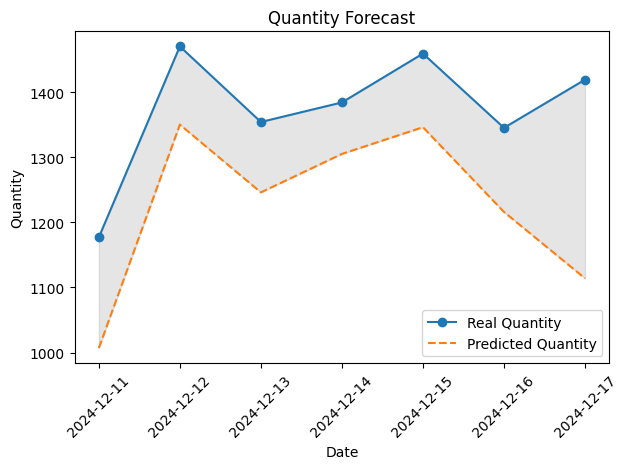

In [56]:
# Plot the lines
plt.plot(regression_eval_df['date'], regression_eval_df['real_quantity'], label='Real Quantity', marker='o')
plt.plot(regression_eval_df['date'], regression_eval_df['predicted_quantity'], label='Predicted Quantity', linestyle='--')

# Fill between the forecast lines
plt.fill_between(regression_eval_df['date'], regression_eval_df['real_quantity'], regression_eval_df['predicted_quantity'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Quantity Forecast')
plt.legend()

# Format the x-axis (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [59]:
#Save Regression Prediction Table to BigQuery
SKU_REGRESSION_PREDICITION_PATH = "sql/regression/quantity/regression_prediction_query.sql"

In [60]:
#Create prediction data
regression_prediction_query = open(SKU_REGRESSION_PREDICITION_PATH).read()

In [61]:
#Create Regression Evaluation Dataframe
regression_preds_df = read_bigquery_data(regression_prediction_query)
regression_preds_df.head()

,date,item_id,store_id,predicted_quantity
0,2024-12-11,1004156,1278,5.0
1,2024-12-11,1023001,1278,3.0
2,2024-12-11,1007331,1278,5.0
3,2024-12-11,1008449,1205,4.0
4,2024-12-11,1008449,1278,5.0


In [62]:
#Create Prediction Data for Regression Model and save to bigquery
create_bigquery_table(regression_preds_df, PROJECT_ID, dataset_id, regression_prediction_table_id)

a-better-mistake-2021.aster_uat.sku_regression_quantity_prediction_data
Table sku_regression_quantity_prediction_data created successfully in BigQuery.


## Blended Model

Here what we will do is take the query in "blended_model_preds.sql" file and use it to take the average between each approach

In [63]:
#Blended Model Table ID
blended_model_predictions_table_id = "blended_predictions"

In [64]:
#Create a blended Model Approach
SKU_BLENDED_MODEL_PREDICTION_PATH = "sql/blended/quantity/blended_model_preds.sql"

In [65]:
blended_prediction_query = open(SKU_BLENDED_MODEL_PREDICTION_PATH).read()

In [66]:
blended_preds_df = read_bigquery_data(blended_prediction_query)
blended_preds_df.head()

,date,item_id,store_id,regression_preds,upper_forecast,avg_forecast,lower_forecast,blended_avg_forecast,blended_lower_forecast,blended_upper_forecast
0,2024-12-11,1002020,1278,2.0,3.9,2.7,1.6,2.35,1.8,2.95
1,2024-12-11,1002020,1278,2.0,3.9,2.7,1.6,2.35,1.8,2.95
2,2024-12-11,1004156,1119,2.0,8.0,3.6,-0.8,2.80,0.6,5.00
3,2024-12-11,1004156,1213,2.0,6.9,3.1,-0.6,2.55,0.7,4.45
4,2024-12-11,1005934,1278,2.0,4.0,3.0,2.0,2.50,2.0,3.00


In [67]:
#Save Blended Predictions to BigQuery Table
create_bigquery_table(blended_preds_df , PROJECT_ID, dataset_id, blended_model_predictions_table_id )

a-better-mistake-2021.aster_uat.blended_predictions
Table blended_predictions created successfully in BigQuery.


In [68]:
#Evaluate Blended Model
blended_model_evaluation_table_id = "blended_evaluation"

In [69]:
#Create blended model path 
BLENDED_MODEL_EVALUATION_PATH = "sql/blended/quantity/blended_model_eval.sql"

In [70]:
blended_evaluation_query = open(BLENDED_MODEL_EVALUATION_PATH).read()

In [71]:
blended_eval_df = read_bigquery_data(blended_evaluation_query)
blended_eval_df.head()

,date,real_quantity,regression_preds,upper_forecast,avg_forecast,lower_forecast,blended_avg_forecast,blended_lower_forecast,blended_upper_forecast
0,2024-12-11,1177.0,853.0,1189.0,869.0,551.0,861.0,702.0,1021.0
1,2024-12-12,1470.0,1172.0,1587.0,1169.0,742.0,1171.0,957.0,1379.0
2,2024-12-13,1354.0,1064.0,1338.0,970.0,597.0,1017.0,830.0,1201.0
3,2024-12-14,1384.0,1070.0,1376.0,983.0,589.0,1026.0,830.0,1223.0
4,2024-12-15,1459.0,1091.0,1545.0,1083.0,624.0,1087.0,858.0,1318.0


In [72]:
#Save blended evaluation to BigQuery Table
create_bigquery_table(blended_preds_df , PROJECT_ID, dataset_id, blended_model_evaluation_table_id  )

a-better-mistake-2021.aster_uat.blended_evaluation
Table blended_evaluation created successfully in BigQuery.


In [73]:
# Create the plot
plt.figure(figsize=(100, 60)) 

<Figure size 10000x6000 with 0 Axes>

<Figure size 10000x6000 with 0 Axes>

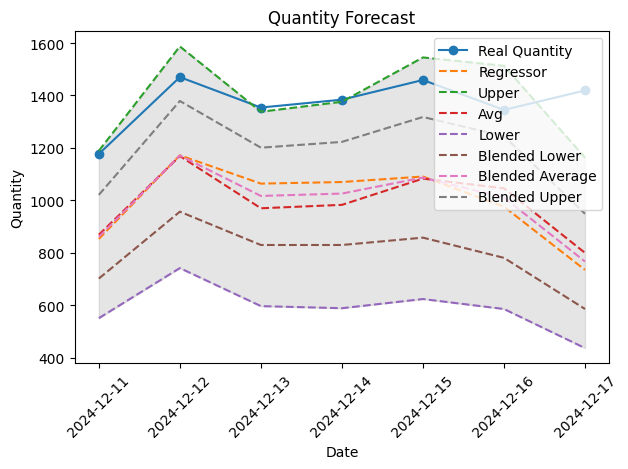

In [74]:
# Plot the lines
plt.plot(blended_eval_df['date'], blended_eval_df['real_quantity'], label='Real Quantity', marker='o')
plt.plot(blended_eval_df['date'], blended_eval_df['regression_preds'], label='Regressor', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['upper_forecast'], label='Upper', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['avg_forecast'], label='Avg', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['lower_forecast'], label='Lower', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['blended_lower_forecast'], label='Blended Lower', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['blended_avg_forecast'], label='Blended Average', linestyle='--')
plt.plot(blended_eval_df['date'], blended_eval_df['blended_upper_forecast'], label='Blended Upper', linestyle='--')

# Fill between the forecast lines
plt.fill_between(blended_eval_df['date'], blended_eval_df['lower_forecast'], blended_eval_df['upper_forecast'], color='gray', alpha=0.2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Quantity Forecast')
plt.legend()

# Format the x-axis (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()